# Tuning Models

We could look at models individually to see how they perform against each other.  It also provides an opportunity to introduce the concept of hyperparameters which are important to consider since many ML methods will use them. Many people are surprised to learn that random Forests (or even a single Decision Tree) can be used to predict a numeric outcome, but they can be. The advantages of using random Forests include the following:

- easy to use
- resistant to overfitting
- accurate use for non linear models
- can be used to predict numeric or binary outcomes 

Disadvantages include:

- the rf function requires setting hyperparameters 
- adjustment of hyperparameters can be specific to the data set
- default vlaues will requie adjustment or "tuning"

Let's look at some of the tree methods (again) since we don't have to worry about scaling and things like that. We want to see if we can get comparable performance from the various methods. 

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

url = "https://raw.githubusercontent.com/steviep42/bios534_spring_2020/master/data/pima.csv"
pm = pd.read_csv(url, sep=',')

X = pm.drop('diabetes',axis=1)
y = pm.diabetes

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

dtc = DecisionTreeClassifier()
dtc.fit(X_train,y_train)
dtc.score(X_test,y_test).round(3)

0.697

So we could try to see how a series of single trees would perform given bootstrap sampling of the data. Note that we would be creating a training and test pair from the existing X_train by samping it with replacement which will result in some duplicated records. After that, we could then use the records that were NOT sampled as a test data set. This is also known as the OOB "out-of-band" samples. 

In [77]:
import numpy as np
from sklearn.utils import resample
from collections import Counter

# Get a bootstrapped sample
idx_spl = resample(np.arange(X_train.shape[0]))
X_train_spl = X_train.iloc[idx_spl]
y_train_spl = y_train.iloc[idx_spl]

# Verify that some records are duplicates as per the 
[count for item, count in Counter(idx_spl).items()][0:10]

idx_oob = np.setdiff1d(np.arange(X_train.shape[0]),idx_spl)
X_oob = X_train.iloc[idx_oob]
y_oob = y_train.iloc[idx_oob]


Let's make a loop to evaluate 20 trees. Each time through the loop, we will work with a variation of the X_train data and store the predicted OOB accuracy. 

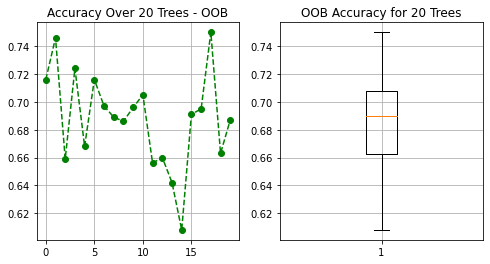

In [100]:
scores = []
for ii in range(20):
    
    # Get a bootstrapped sample
    idx_spl = resample(np.arange(X_train.shape[0]))
    X_train_spl = X_train.iloc[idx_spl]
    y_train_spl = y_train.iloc[idx_spl]


    idx_oob = np.setdiff1d(np.arange(X_train.shape[0]),idx_spl)
    X_oob = X_train.iloc[idx_oob]
    y_oob = y_train.iloc[idx_oob]
    
    dtc = DecisionTreeClassifier()
    dtc.fit(X_train_spl,y_train_spl)
    scores.append(dtc.score(X_oob,y_oob).round(3))

import matplotlib.pyplot as plt
# Creates two subplots and unpacks the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(8,4))

ax1.plot(range(len(scores)),scores,'go--')
ax1.set_title("Accuracy Over 20 Trees - OOB")
ax1.grid()

ax2.boxplot(scores)
ax2.set_title("OOB Accuracy for 20 Trees")
ax2.grid()

We don't really see a pattern here except that the accuracy varies over a range of values. The highest appears to be around .75 but that's not the median. We haven't attempted to alter any of the default parameters used by the method itself so the variation we see is likely due to the bootstrapping. 

Now we could experiment with the "criterion" and "splitter" arguments to see if varying these will impact (or improve) the accuracy of any of the trees we might make. Let's see what we can get from this approach.

In [184]:
criterion = ['gini','entropy']
splitter = ['best','random']

scoring = []
for c in criterion:
    for s in splitter:
         dtc = DecisionTreeClassifier(criterion=c,splitter=s)
         dtc.fit(X_train,y_train)
         scoring.append([c,s,dtc.score(X_test,y_test).round(3)])
 
score_df = pd.DataFrame(scoring,columns=['criterion','splitter','accuracy'])
score_df.sort_values(by=['accuracy'], inplace=True, ascending=False)

print("Best Combination of paramters :\n",score_df.head(1))

Best Combination of paramters :
   criterion splitter  accuracy
2   entropy     best     0.732


Well that seems okay but it didn't necessarily improve things although we didn't look at any variations in the data. That is, we didn't do any bootstrapping or cross validation so we the best we could come up with was around .72 accuracy. On the other hand, do we need to be doing this by hand when there is a function that can help us figure out the best parameters to use which is also based on cross fold validation ?

In [183]:
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'criterion': ['gini','entropy'], 
   'splitter': ['best','random']}
]

dtc = DecisionTreeClassifier()
gridsearch = GridSearchCV(dtc, param_grid, cv=5, return_train_score=True)
gs_results = gridsearch.fit(X_train, y_train)

print("Best parameters are: ",gs_results.best_params_)
print("Best accuracy: ",gs_results.best_score_.round(3))

Best parameters are:  {'criterion': 'entropy', 'splitter': 'best'}
Best accuracy:  0.728


So if we move back to the RandomForests we can see that it will do both bootstrapping while building a specified number of trees while producing an aggregate model that can be used to make predictions. Let's rerun it to see what the baseline accuracy might look like. Straight out of the box, it offers a higher level of accuracy than the single DecisionTreeClassifier. 

In [148]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rf.score(X_test,y_test).round(3)

0.745

Without any tweaking, we see that the Random Forest method seems to produce the best accuracy which isn't that suprising since it looks a number of trees as opposed to a single one. The way bagged trees work is to use bootstrap sampling to look at different versions of the input for each tree that it makes. 

The number of trees to make is specified before running the function. Since the sampling is bootstrap-based, some of the rows from the input will be duplicated perhaps more than once whereas other rows will not be involved at all in the training. These are commonly known as Out of Bag samples. After a give tree is formed it is then used to predict performance on the OOB samples to arrive at an OOB error.

A reasonable question might be, how well does the accuracy perform with a certain number of trees ? 

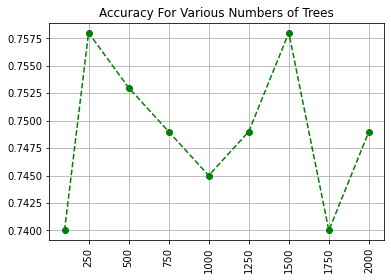

In [176]:
num_of_trees = [100, 250, 500, 750, 1000,1250,  1500, 1750, 2000]

scores = []
for ii in num_of_trees:
    rf = RandomForestClassifier(n_estimators=ii)
    rf.fit(X_train,y_train)
    scores.append(rf.score(X_test,y_test).round(3))

plt.plot(num_of_trees,scores,'go--')
plt.title("Accuracy For Various Numbers of Trees")
plt.xticks(rotation=90)
plt.grid()

As with the single decision tree, we could look at some type of hyperparameter tuning scenario to see if we could improve performance. It seems that even the worst accuracy value for the Random Forest seems to match the best accuracy emerging from the single Decision Tree. 

In [262]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

rfc = RandomForestClassifier(bootstrap=True)

cv_rfc = GridSearchCV(estimator=rfc, 
                      param_grid=param_grid, 
                      cv= 5,
                      n_jobs=-1)
cv_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [263]:
cv_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 200}

In [264]:
print("Best Score: ",cv_rfc.best_score_.round(2))

Best Score:  0.78


In [265]:
from sklearn.metrics import accuracy_score
rfc = RandomForestClassifier(bootstrap=True,
                             criterion='gini',
                             max_depth=6,
                             max_features='log2',
                             n_estimators=200)

ypreds = rfc.fit(X_train,y_train).predict(X_test)
accuracy_score(y_test, ypreds).round(3)

0.745

In reality, we dont' have to refit the random forest because the GridSearchCV process provides the best performing model in the form of **best_estimator_**.

In [269]:
best_rf = cv_rfc.best_estimator_
print(best_rf)

#
ypreds = best_rf.fit(X_train,y_train).predict(X_test)
accuracy_score(y_test, ypreds).round(3)

RandomForestClassifier(max_depth=8, max_features='log2', n_estimators=200)


0.753

There are other types of searches wherein we can specify a distribution or range of values which represent a source to be sampled. That is, not every value will be tried. With GridSearchCV, every combination will be attempted so the search is exhaustive. This is also why doing a gridsearch across a very large parameter space can consume lots of CPU and memory. 

Random search can be just as aggressive although it is possible to specify how many samples will be taken from a parameter space so as to mitigage possible CPU over load. The **n_iter** of argument, which is 10 by default, indicates the number of times to sample from a parameter. 

In [270]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': range(1,20),
               'min_samples_split': range(2,9),
               'n_estimators': np.arange(100,1000)}

rfc = RandomForestClassifier()
rs_rfc = RandomizedSearchCV(estimator=rfc, 
                            param_distributions=random_grid, 
                            cv = 5,
                            n_iter=15,
                            n_jobs=-1,
                            random_state=123)

rs_rfc.fit(X_train,y_train)
print("Best Params: \n",rs_rfc.best_params_)
print("Accuracy:",rs_rfc.best_params_)

Best Params: 
 {'n_estimators': 130, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': True}
Accuracy: {'n_estimators': 130, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': True}


In [272]:
#
ypreds = rs_rfc.best_estimator_.predict(X_test)
accuracy_score(y_test, ypreds).round(3)

0.762

## Validation Set

When building a model, we generate a training and test data set. We use the former to build a model and, if we are using something like the caret package, that process involves cross fold validation or bootstrap sampling to generate a good estimate for out-of-sample error. We then apply the model to the test data frame.

If we are using a method that has hyperparamters then maybe we want an intermediate data set to help validate our ultimate choice of hyperparameters. By taking this approach we can still keep our test data set off to the side for later use with the trained and validated model. Using this idea doesn’t require us to do much beyond generating a third data set.

- The training set is used to build the classifier
- The validation set is used to tune the algorithm hyperparameters repeatedly. 
- So there will be some overfitting here, but that is why there is another stage:

The test set must not be touched until the classifier is final to prevent 
overfitting. It serves to estimate the true accuracy, if you would put the model 
into production. The only problem is that there really isn't a **scikit-learn** function to help us with the creation of the three datasets.  

In [244]:
train, validate, test = np.split(pm.sample(frac=1), 
                                 [int(.6*len(pm)), int(.8*len(pm))])

rfc = RandomForestClassifier()

X_v_train = train.drop('diabetes',axis=1)
y_v_train = train.diabetes
#
X_v_test  = test.drop('diabetes',axis=1)
y_v_test  = test.diabetes

rfc.fit(X_v_train,y_v_train)
rfc.score(X_v_test,y_v_test).round(2)

0.73

So now we can do hyperparamter tuning using the validation set. The important thing to note here is that we aren't using the test data frame at all to do any training. By using the validation set we are also introducing some needed variation to the hyperparameter tuning process. 

In [273]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': range(1,20),
               'min_samples_split': range(2,9),
               'n_estimators': np.arange(100,1000)}

rfc = RandomForestClassifier()
rs_rfc = RandomizedSearchCV(estimator=rfc, 
                            param_distributions=random_grid, 
                            cv = 5,
                            n_iter=15,
                            n_jobs=-1,
                            random_state=123)

# 
validate_train_x = validate.drop('diabetes',axis=1)
validate_train_y = validate.diabetes

# 
rs_rfc.fit(validate_train_x, validate_train_y)
print("Best Params: \n",rs_rfc.best_params_)
print("Accuracy:",rs_rfc.best_score_)

Best Params: 
 {'n_estimators': 934, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': False}
Accuracy: 0.76


And finally, we will fit the Random Forest using the "optimal" parameter set after which we will see how it performs on the test dataset. 

In [274]:
rs_rfc.best_estimator_.fit(validate_train_x,validate_train_y)
optimal_model.score(X_v_test,y_v_test).round(2)

0.77

See https://jessesw.com/XG-Boost/